## Geometric Brownian Motion to Model Stock Prices
Adapted from https://github.com/bottama/stochastic-asset-pricing-in-continuous-time/tree/main

In [9]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

### Get Stock Prices

In [10]:
def download_stock_prices(stock_name, start_date, end_date):
    prices = yf.download(tickers=stock_name, start=start_date, end=end_date)['Close']
    return prices

### Pre-Process Data

In [11]:
def calculate_daily_returns(prices):
    # daily_returns = ((prices / prices.shift(1)) - 1)[1:]
    daily_returns = ((np.log(prices / prices.shift(1))))[1:]
    return daily_returns

### Calculate Model Parameters

In [12]:
def calculate_parameters(prices, end_date, pred_end_date, scen_size):
    train_set = prices.loc[:end_date]
    test_set = prices.loc[end_date:pred_end_date]
    daily_returns = calculate_daily_returns(train_set)

    So = train_set[-1]
    dt = 1
    n_of_wkdays = pd.date_range(start=pd.to_datetime(end_date, format="%Y-%m-%d") + pd.Timedelta('1 days'),
                                end=pd.to_datetime(pred_end_date, format="%Y-%m-%d")).to_series().map(
        lambda x: 1 if x.isoweekday() in range(1, 6) else 0).sum()
    T = n_of_wkdays
    N = T / dt
    t = np.arange(1, int(N) + 1)
    mu = np.mean(daily_returns)
    sigma = np.std(daily_returns)
    b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
    W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

    return So, dt, T, N, t, mu, sigma, b, W, train_set, test_set

def calculate_drift_diffusion(So, t, N, mu, sigma, b, W, scen_size):
    drift = (mu - 0.5 * sigma ** 2) * t
    diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}
    return drift, diffusion

### Make Predictions

In [13]:
def make_predictions(So, N, drift, diffusion, scen_size):
    S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)])
    S = np.hstack((np.array([[So] for scen in range(scen_size)]), S))  # add So to the beginning series
    S_max = [S[:, i].max() for i in range(0, int(N))]
    S_min = [S[:, i].min() for i in range(0, int(N))]
    S_pred = .5 * np.array(S_max) + .5 * np.array(S_min)
    return S_pred

### Analyse and Plot Predictions

In [39]:
def calculate_mse(test_set, S_pred):
    final_df = pd.DataFrame(data=[test_set.reset_index()['Close'], S_pred], index=['real', 'pred']).T
    final_df.index = test_set.index
    mse = 1 / len(final_df) * np.sum((final_df['pred'] - final_df['real']) ** 2)
    return mse

def plot_predictions(final_df, mse, ticker):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.suptitle(f'Predicted Price vs Actual Price for {str(ticker)}', fontsize=20)
    plt.title('Mean Squared Error (MSE): {}'.format(np.round(mse, 2)))
    plt.ylabel('USD Price')
    plt.plot(final_df)
    plt.legend(['Real Price', 'Predicted Price'],
               loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)
    plt.show()

### Run Model

In [40]:
def run_model(stock_name, start_date, end_date, pred_end_date, scen_size):
    prices = download_stock_prices(stock_name, start_date, pred_end_date)
    So, dt, T, N, t, mu, sigma, b, W, train_set, test_set = calculate_parameters(prices, end_date, pred_end_date, scen_size)
    drift, diffusion = calculate_drift_diffusion(So, t, N, mu, sigma, b, W, scen_size)
    S_pred = make_predictions(So, N, drift, diffusion, scen_size)
    mse = calculate_mse(test_set, S_pred)
    final_df = pd.DataFrame(data=[test_set.reset_index()['Close'], S_pred], index=['real', 'pred']).T
    final_df.index = test_set.index
    plot_predictions(final_df, mse, stock_name)

### Setup Fixed Model Parameters

In [33]:
start_date = '2020-10-01'
end_date = '2020-11-30'
pred_end_date = '2020-12-18'
scen_size = 10000

### Model 14 Day Predicitons for Each Stock

[*********************100%***********************]  1 of 1 completed


C:\Users\conck\AppData\Local\Temp\ipykernel_24088\4049594455.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  So = train_set[-1]


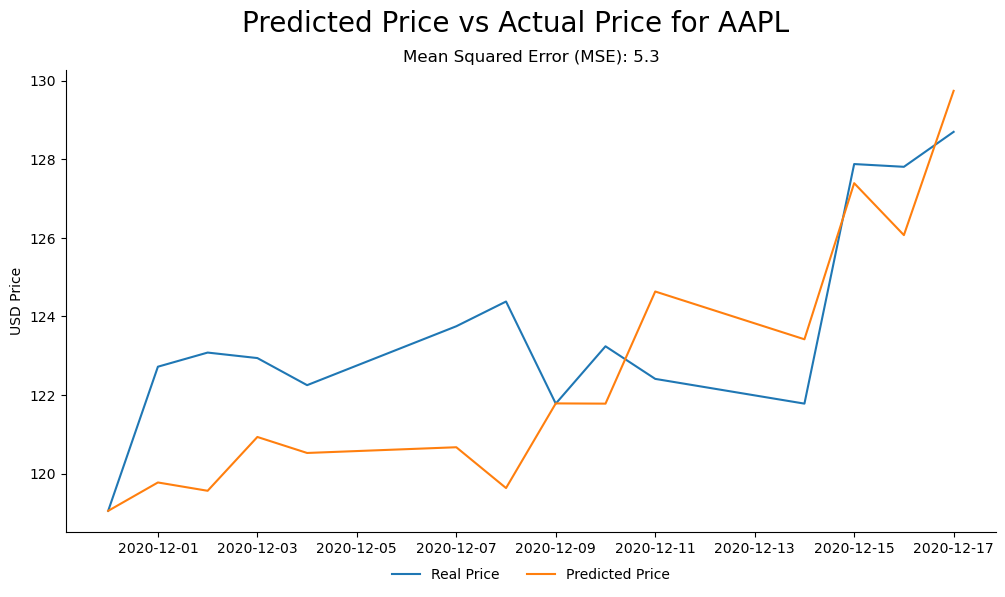

[*********************100%***********************]  1 of 1 completed


C:\Users\conck\AppData\Local\Temp\ipykernel_24088\4049594455.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  So = train_set[-1]


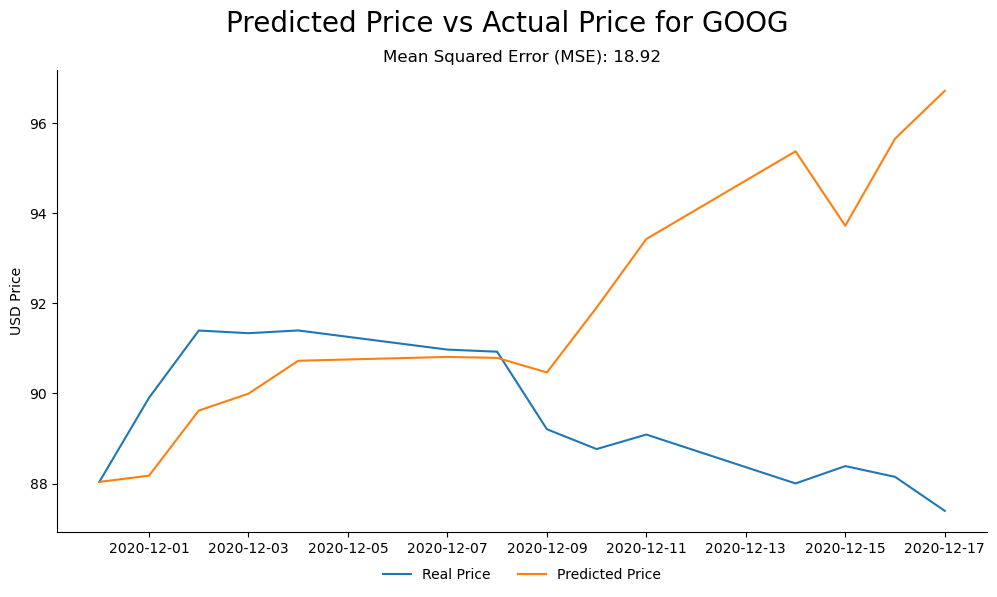

[*********************100%***********************]  1 of 1 completed


C:\Users\conck\AppData\Local\Temp\ipykernel_24088\4049594455.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  So = train_set[-1]


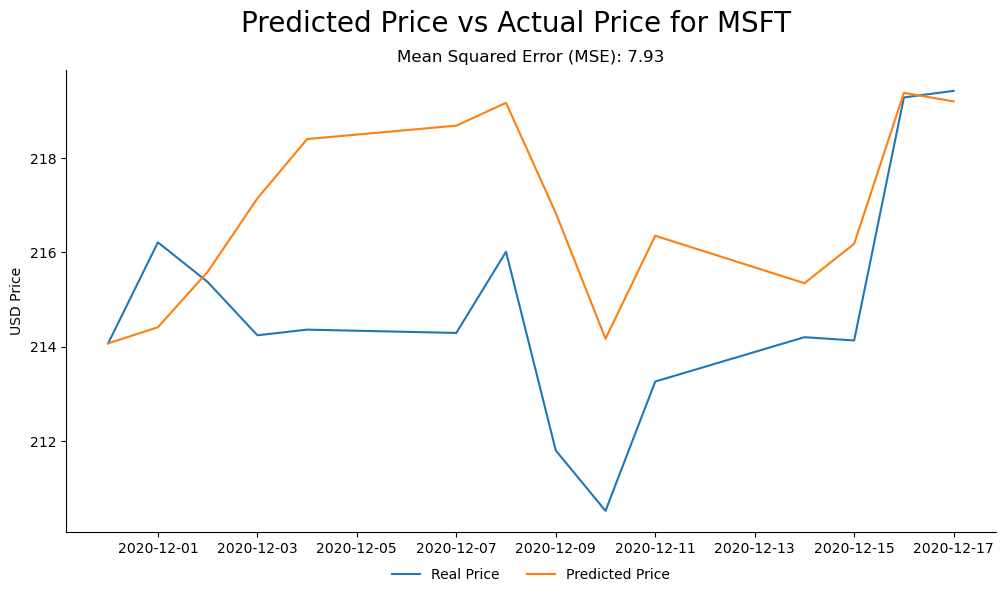

[*********************100%***********************]  1 of 1 completed


C:\Users\conck\AppData\Local\Temp\ipykernel_24088\4049594455.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  So = train_set[-1]


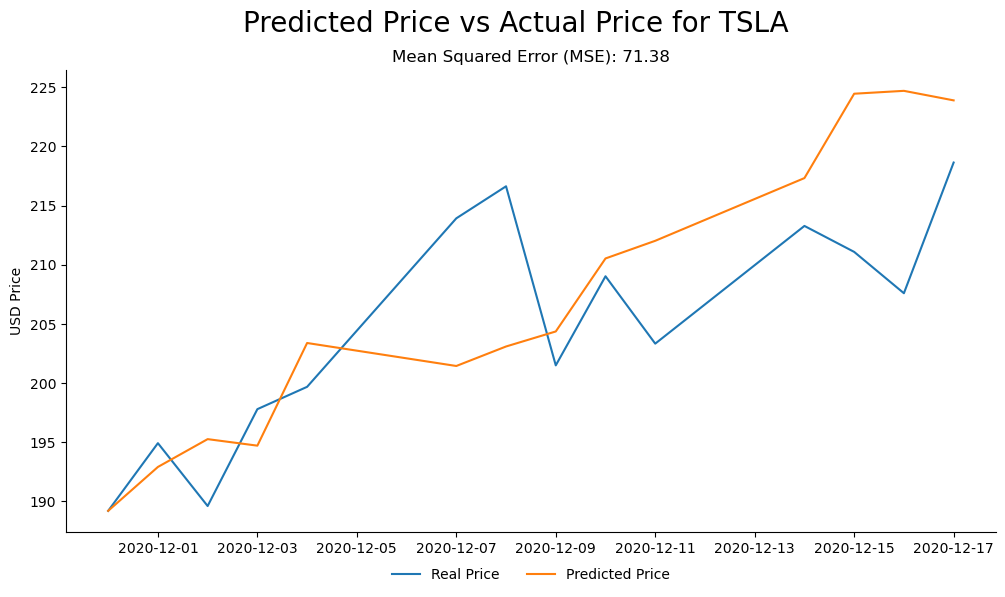

In [41]:
stocks = ["AAPL", "GOOG", "MSFT", "TSLA"]

for stock_name in stocks:
    run_model(stock_name, start_date, end_date, pred_end_date, scen_size)